# Asymptotic Fingerprints of Cone Differential Operators

End-to-end prototype: dataset → exponent extraction → fingerprint visuals.

`./AppData/Local/Programs/Python/Python310/Scripts/pip install matplotlib`


In [34]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from pathlib import Path
from typing import Tuple, List, Dict

plt.rcParams.update({
    "figure.dpi": 140,
    "figure.figsize": (5, 3.2),
    "font.size": 10,
    "lines.linewidth": 1,
    "lines.markersize": 1,
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": False,
    "axes.titlepad": 4,
    "grid.linestyle": ":",
    "grid.linewidth": 0.4,
    "legend.frameon": False,
})


## Utilities: spectra, Mellin indicial roots, simulation, and fitting

In [35]:
def sphere_eigenvalues(n:int, L:int) -> Tuple[np.ndarray, np.ndarray]:
    l = np.arange(L+1)
    lam = l*(l + n - 1)
    return l, lam

def torus_eigenvalues(n:int, K:int) -> Tuple[np.ndarray, np.ndarray]:
    ks = []
    for idxs in np.ndindex(*([2*K+1]*n)):
        vec = np.array(idxs) - K
        if np.all(vec == 0):
            continue
        ks.append(vec)
    ks = np.array(ks, dtype=int)
    norms2 = np.sum(ks**2, axis=1)
    lam = (2*np.pi)**2 * norms2.astype(float)
    order = np.argsort(lam)
    ks = ks[order]
    lam = lam[order]
    return ks, lam

def mellin_poles_qpm(n:int, lambdas:np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    beta = (n-1)/2.0
    disc = beta**2 - lambdas
    sqrt_disc = np.sqrt(disc + 0j)
    q_plus = beta + sqrt_disc
    q_minus = beta - sqrt_disc
    return q_plus, q_minus

def pick_domain_modes(qs:np.ndarray, num:int=3, strategy:str="top_real") -> np.ndarray:
    order = np.argsort(-qs.real)
    qs_sorted = qs[order]
    uniq = []
    for q in qs_sorted:
        if all(abs(q.real - u.real) > 1e-10 or abs(q.imag - u.imag) > 1e-10 for u in uniq):
            uniq.append(q)
    qs_unique = np.array(uniq, dtype=complex)
    if len(qs_unique) == 0:
        return np.array([], dtype=complex)
    if strategy == "top_real":
        sel = qs_unique[:num]
    elif strategy == "mid_real":
        m = len(qs_unique)//2
        a = max(0, m - num//2)
        sel = qs_unique[a:a+num]
    else:
        sel = qs_unique[-num:]
    return sel

def simulate_signal_from_modes(qs:np.ndarray, x:np.ndarray, rng:np.random.Generator, noise_sigma:float=0.02) -> Tuple[np.ndarray, np.ndarray]:
    if len(qs) == 0:
        return np.ones_like(x), np.array([])
    coeffs = np.abs(rng.normal(1.0, 0.4, size=len(qs))) + 0.2
    u = np.zeros_like(x, dtype=np.complex128)
    for c, q in zip(coeffs, qs):
        u += c * x**(-q)
    mag = np.abs(u)
    noise = noise_sigma * mag * rng.normal(0, 1, size=mag.shape)
    u_obs = (mag + noise).clip(min=1e-300)
    return u_obs, coeffs

def fit_leading_exponent(x:np.ndarray, y:np.ndarray) -> float:
    X = np.vstack([np.ones_like(x), -np.log(x)]).T
    theta, *_ = np.linalg.lstsq(X, np.log(y), rcond=None)
    _, qhat = theta
    return float(qhat)

def greedy_multimode_fit(x:np.ndarray, y:np.ndarray, max_modes:int=3, tol:float=1e-3) -> List[Tuple[float, float]]:
    residual = y.copy()
    fitted = []
    for _ in range(max_modes):
        qhat = fit_leading_exponent(x, residual)
        Chat = np.exp(np.mean(np.log(residual) + qhat*np.log(x)))
        model = Chat * x**(-qhat)
        new_res = np.abs(residual - model)
        improvement = (np.linalg.norm(residual - new_res) / (np.linalg.norm(residual) + 1e-12))
        fitted.append((qhat, Chat))
        residual = new_res + 1e-16
        if improvement < tol:
            break
    fitted.sort(key=lambda t: -abs(t[1]))
    return fitted


## Experiment runner and plotting

In [36]:
@dataclass
class ExperimentConfig:
    name: str
    cross_section: str  # 'sphere' or 'torus'
    n: int
    L_or_K: int
    domain_strategy: str
    modes: int
    x_min: float = 1e-5
    x_max: float = 5e-2
    N_x: int = 250
    noise_sigma: float = 0.02
    seed: int = 0

def run_experiment(cfg:ExperimentConfig, outdir:Path) -> Dict:
    rng = np.random.default_rng(cfg.seed)
    if cfg.cross_section == 'sphere':
        _, lambdas = sphere_eigenvalues(cfg.n, cfg.L_or_K)
    else:
        _, lambdas = torus_eigenvalues(cfg.n, cfg.L_or_K)
    q_plus, q_minus = mellin_poles_qpm(cfg.n, lambdas)
    indicial = np.concatenate([q_plus, q_minus])

    domain_q = pick_domain_modes(indicial, num=cfg.modes, strategy=cfg.domain_strategy)
    x = np.geomspace(cfg.x_min, cfg.x_max, cfg.N_x)
    y, coeffs = simulate_signal_from_modes(domain_q, x, rng, cfg.noise_sigma)

    fitted = greedy_multimode_fit(x, y, max_modes=cfg.modes, tol=1e-3)
    qhats = np.array([q for q, _ in fitted], dtype=float)

    q_true_lead = float(np.max(domain_q.real)) if len(domain_q)>0 else np.nan
    q_hat_lead = float(qhats[0]) if len(qhats)>0 else np.nan
    lead_abs_err = abs(q_true_lead - q_hat_lead) if np.isfinite(q_true_lead) and np.isfinite(q_hat_lead) else np.nan

    exp_dir = outdir / cfg.name
    exp_dir.mkdir(parents=True, exist_ok=True)
    pd.DataFrame({"x": x, "u_abs": y}).to_csv(exp_dir / "signal.csv", index=False)

    # Fingerprint map (inline)
    plt.figure(figsize=(5,5))
    plt.scatter(indicial.real, indicial.imag, s=1, label="Indicial roots")
    if len(domain_q) > 0:
        plt.scatter(domain_q.real, domain_q.imag, s=8, marker='s', label="Domain modes")
    if len(qhats) > 0:
        plt.scatter(qhats, np.zeros_like(qhats), s=8, marker='x', label="Observed exponents")
    plt.axhline(0, linestyle=':')
    plt.xlabel("Re(q)")
    plt.ylabel("Im(q)")
    plt.title(f"Fingerprint Map — {cfg.name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Signal with leading fit
    x_fit = np.geomspace(cfg.x_min, cfg.x_max, 200)
    if np.isfinite(q_hat_lead):
        Chat = np.exp(np.mean(np.log(y) + q_hat_lead*np.log(x)))
        y_fit = Chat * x_fit**(-q_hat_lead)
    else:
        y_fit = np.zeros_like(x_fit)

    plt.figure(figsize=(6,4))
    plt.loglog(x, y, marker='o', linestyle='-', label='|u(x)|')
    if np.isfinite(q_hat_lead):
        plt.loglog(x_fit, y_fit, linestyle='--', label=f'fit q̂≈{q_hat_lead:.4f}')
    plt.xlabel('x')
    plt.ylabel('|u(x)|')
    title_tail = f"true q*≈{q_true_lead:.4f}, err≈{lead_abs_err:.3e}" if np.isfinite(q_true_lead) else "no domain modes"
    plt.title(f"Signal + Leading Fit — {cfg.name}\n{title_tail}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    meta = {
        "name": cfg.name,
        "cross_section": cfg.cross_section,
        "n": cfg.n,
        "L_or_K": cfg.L_or_K,
        "domain_strategy": cfg.domain_strategy,
        "modes": cfg.modes,
        "noise_sigma": cfg.noise_sigma,
        "q_true_lead": q_true_lead,
        "q_hat_lead": q_hat_lead,
        "lead_abs_err": lead_abs_err,
    }
    (exp_dir / "meta.json").write_text(pd.Series(meta).to_json(orient="columns"))
    return meta


## Run experiments (S²/S³ and T²/T³ variants)

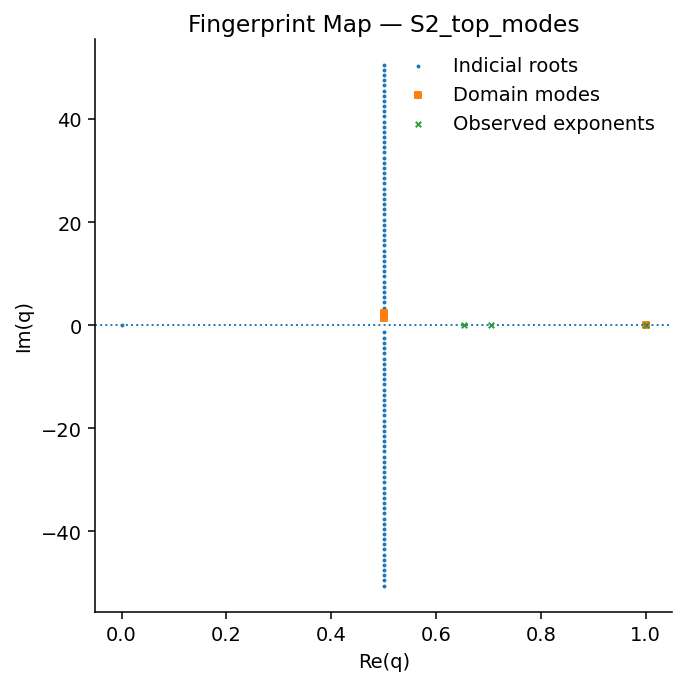

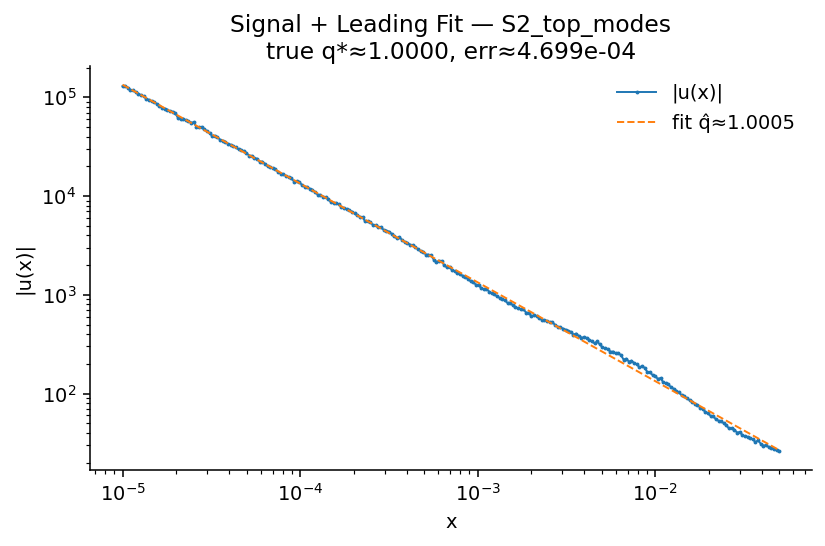

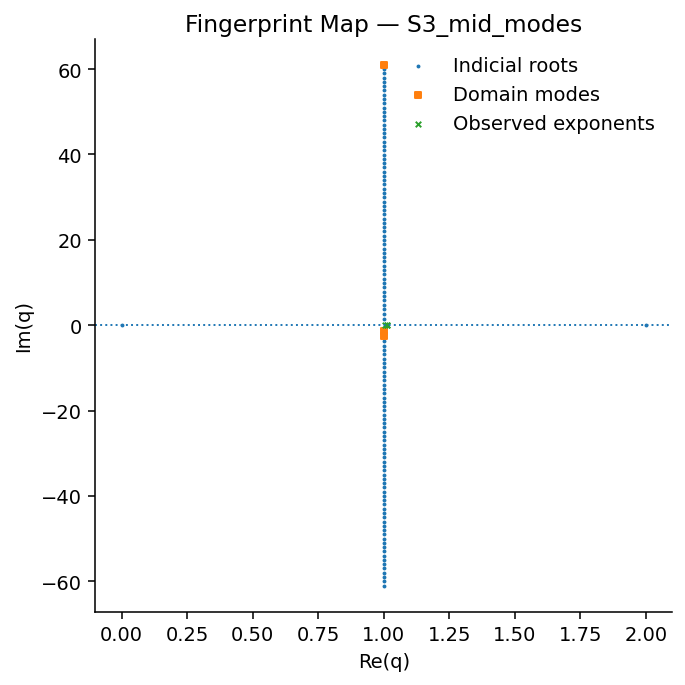

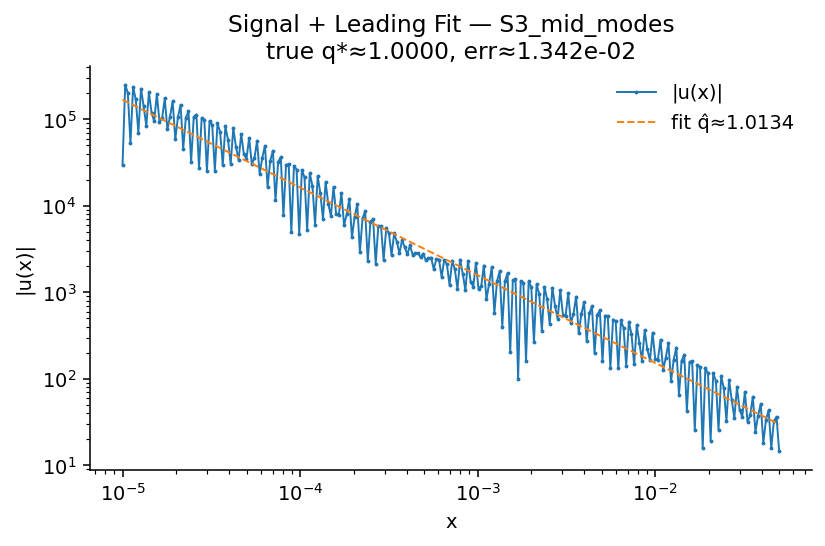

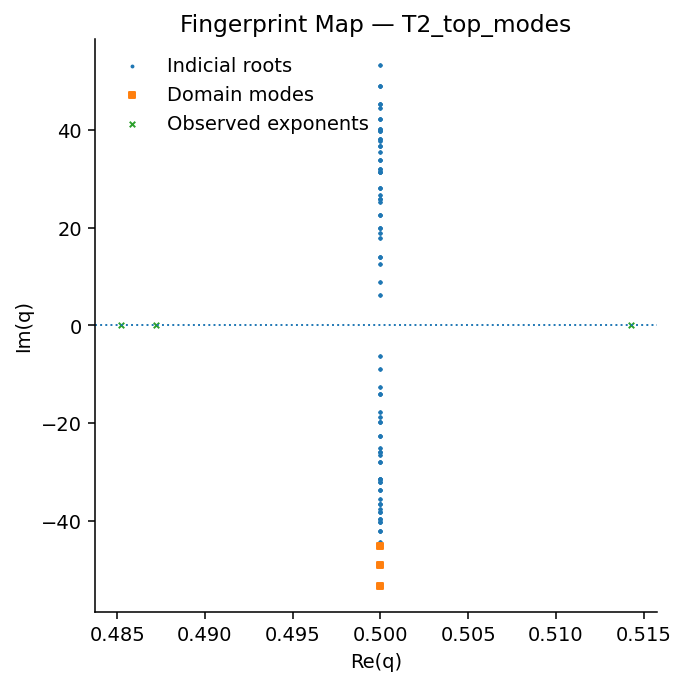

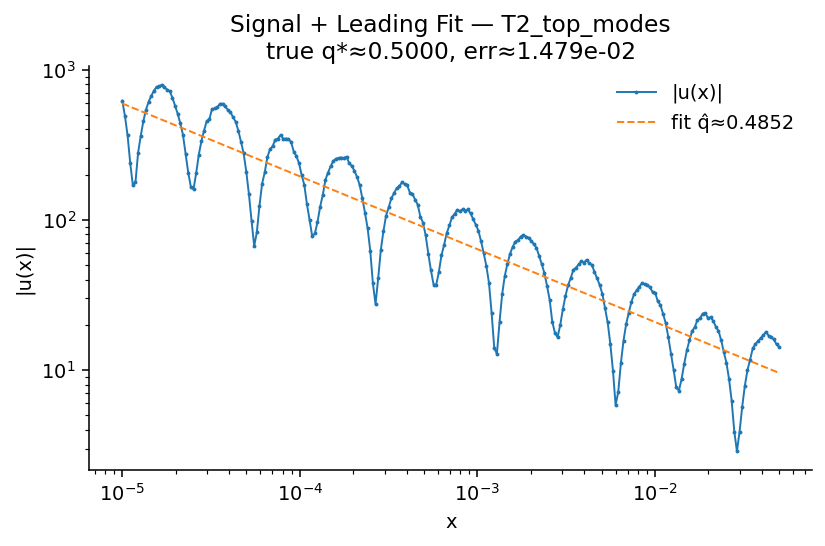

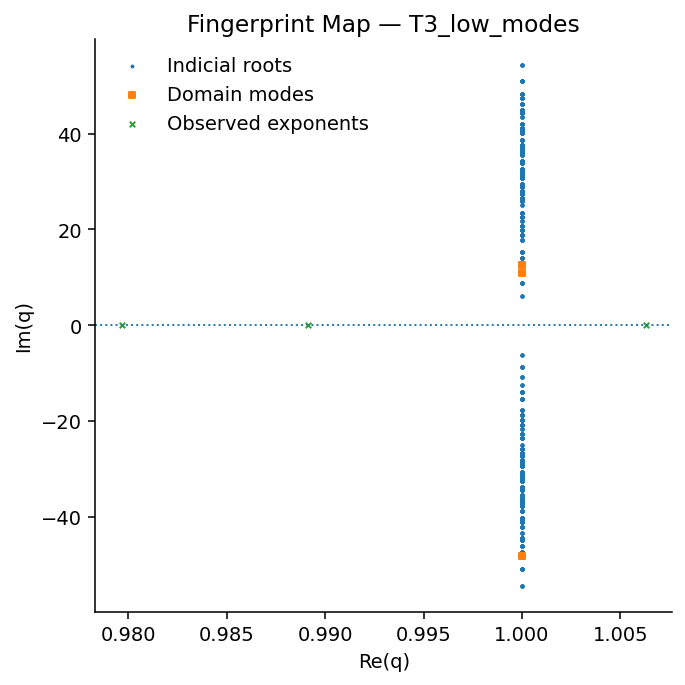

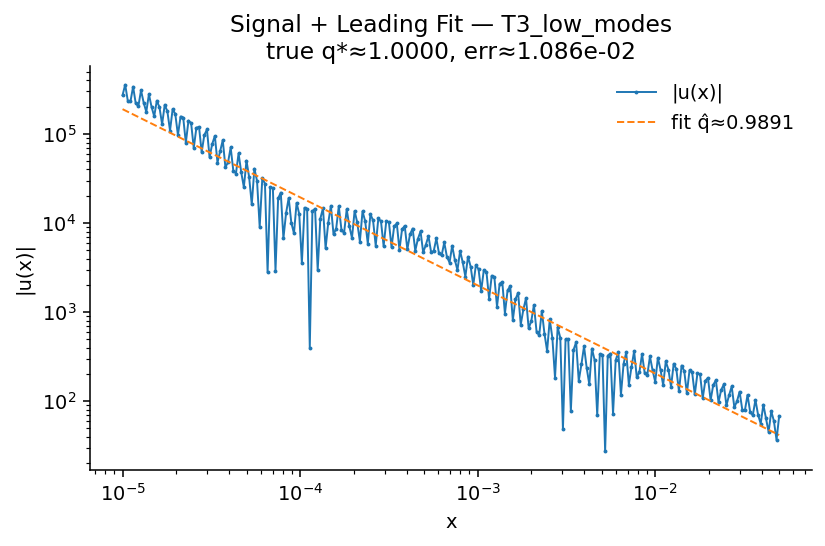

,name,cross_section,n,L_or_K,domain_strategy,modes,noise_sigma,q_true_lead,q_hat_lead,lead_abs_err
0,S2_top_modes,sphere,2,50,top_real,3,0.02,1.0,1.000470,0.000470
1,S3_mid_modes,sphere,3,60,mid_real,3,0.02,1.0,1.013416,0.013416
2,T2_top_modes,torus,2,6,top_real,3,0.02,0.5,0.485208,0.014792
3,T3_low_modes,torus,3,5,low_real,3,0.02,1.0,0.989143,0.010857


In [37]:
experiments = [
    ExperimentConfig(name='S2_top_modes', cross_section='sphere', n=2, L_or_K=50, domain_strategy='top_real', modes=3, seed=1),
    ExperimentConfig(name='S3_mid_modes', cross_section='sphere', n=3, L_or_K=60, domain_strategy='mid_real', modes=3, seed=2),
    ExperimentConfig(name='T2_top_modes', cross_section='torus', n=2, L_or_K=6, domain_strategy='top_real', modes=3, seed=3),
    ExperimentConfig(name='T3_low_modes', cross_section='torus', n=3, L_or_K=5, domain_strategy='low_real', modes=3, seed=4),
]

metas = []
for cfg in experiments:
    metas.append(run_experiment(cfg, outdir))

summary = pd.DataFrame(metas)
summary
